In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

# Load in the data

In [2]:
df = pd.read_csv('complaints_cleaned_comb.csv')
df = df.sample(n=4673)
df.head()

,Product,Consumer_complaint_narrative,Category_ID
697283,Debt collection,"On Thursday, XX/XX/XXXX I receive a call from ...",5
112974,"Credit reporting, credit repair services, or o...",THESE ACCOUNTS LISTED DO NOT BELONG TO ME SOMO...,4
96996,"Credit reporting, credit repair services, or o...","I contacted XXXX, XXXX and Equifax credit bur...",4
346921,"Credit reporting, credit repair services, or o...",Experian has been notified six times of the er...,4
240809,Mortgage,I have an FHA loan for my home. When I purchas...,7


Create a dataframe and dictionary necessary for the term-product correlation code.

In [3]:
category_id_df = df[['Product', 'Category_ID']].drop_duplicates().sort_values('Category_ID')
category_to_id = dict(category_id_df.values)

# Visualize the Consumer Complaint counts

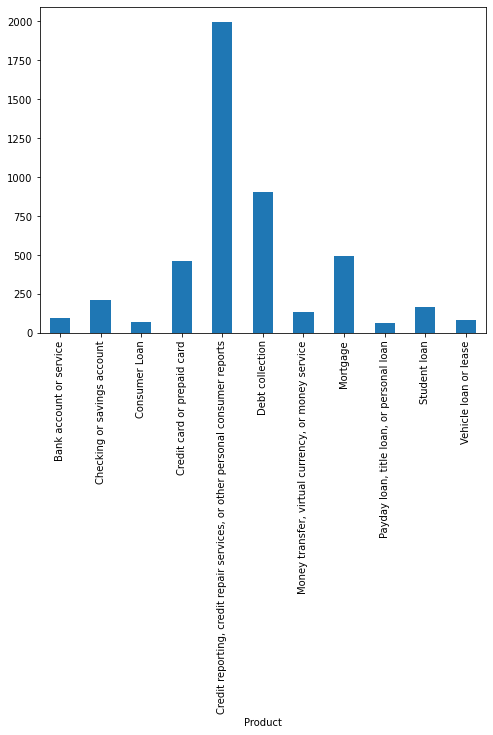

Credit reporting, credit repair services, or other personal consumer reports    1995
Debt collection                                                                  905
Mortgage                                                                         492
Credit card or prepaid card                                                      464
Checking or savings account                                                      209
Student loan                                                                     166
Money transfer, virtual currency, or money service                               133
Bank account or service                                                           94
Vehicle loan or lease                                                             82
Consumer Loan                                                                     69
Payday loan, title loan, or personal loan                                         64
Name: Product, dtype: int64

In [4]:
# plot frequencies
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

df.Product.value_counts()

We're seeing lots of bias towards credit reporting, debt collection, and mortgage. We can fix this with resampling via SMOTE etc., but we want the algorithm to have high accuracy in predicting the majority classes while maintaining decent accuracy in predicting the minority classes. Thus, we'll leave the training data as it is.

# Start using Consumer Complaint Narratives to determine keywords

Convert Consumer Complaint Narratives to TF-IDF features.

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.Category_ID
features.shape

(4673, 13409)

Feed the TF-IDF features into feature_selection.chi2 so we can determine and print the words/phrases in the Consumer Complaint Narratives that are highly correlated with Products.

In [6]:
# iterate through the different products and print their most correlated unigrams and bigrams
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])    # indices of sorted features_chi2 array
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-2:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-2:])))

# 'Bank account or service':
  . Most correlated unigrams:
       . overdrawn
       . overdraft
  . Most correlated bigrams:
       . new checking
       . overdraft protection
# 'Checking or savings account':
  . Most correlated unigrams:
       . checking
       . deposited
  . Most correlated bigrams:
       . deposited check
       . checking account
# 'Consumer Loan':
  . Most correlated unigrams:
       . car
       . vehicle
  . Most correlated bigrams:
       . xxxx dealership
       . car repossessed
# 'Credit card or prepaid card':
  . Most correlated unigrams:
       . amex
       . card
  . Most correlated bigrams:
       . american express
       . credit card
# 'Credit reporting, credit repair services, or other personal consumer reports':
  . Most correlated unigrams:
       . equifax
       . report
  . Most correlated bigrams:
       . identity theft
       . credit report
# 'Debt collection':
  . Most correlated unigrams:
       . collection
       . debt
  . Most co